<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning%20(TF)/Value%20Based/Dueling%20DDQN%20with%20PER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import gym
import time
from itertools import count

# Prioritized Replay Buffer (PER)

PER helps us to build a smarter way to replay experiences. It prioritize the replay of meaningful experiences.
In DQN, DDQN and Dueling DDQN we sampled experiences from the replay buffer uniformly at random. A better strategy would be to sample and learn from "surprising" experiences with an unexpected value.
Intuitively, we can think of them as follows: if a sample leads to a large difference between expectation and reality, then the agent should learn something from that.

The agent can obtain this measure of surprise by the absolute TD error. In PER, we will use TD errors to calculate priorities and from priorities we calculate probabilities. Using the probabilities, we can then sample from the replay buffer.

# Priotization

The are two ways to priotize samples:

## Rank-based prioritization

For rank-based prioritization, we calculate the priorities as the reciprocal of the rank of that sample:

$p_i = \dfrac{1} {rank(i)}$

Meaning of $rank(i)$: the position of sample $i$ when sorted in descending order by the absolute TD error. E.g. sample with highest absolute TD error gets rank 1.

## Proportional prioritization

In proportional prioritization, we can use the absolute TD error of sample $i$, denoted as $\delta_i$ and add a small constant, denoted as $\epsilon$, to make sure zero TD error samples still have a chance of being replayed:

$p_i = |\delta_i| + \epsilon$

## From scaled priorities to probabilities

The priority values $p_i$ are getting scaled by exponentiating it to $\alpha$ which is a hyperparameter in the range $[0,1].$ $\alpha$ allows us to interpolate between uniform and prioritized sampling. Further, it allows to perform stochastic prioritization.

If $\alpha$ is 0: all values become 1; an equal priority.

If $\alpha$ is 1: all values are the same as the absolute TD error; the priority is proportional to the absolute TD error

If $\alpha$ is between 0 and 1: we blend the two sampling strategies

To convert from scaled priorities to actual propbabilities only by dividing their values by the sum of the values:

$P(i) = \dfrac {p_{i}^\alpha} {\sum_{k} p_{k}^\alpha}$


These probabilities are then used later to draw samples from the replay buffer.

# Weighted importance-sampling weights

Another importance concept is to mitigate the pritization bias using weights. The sampling of experiences from the replay buffer in the implementations of DQN, DDQN and dueling DDQN was done uniformly at random. Since priotization means we are not doing that, then the probability distribution of samples we get is different from the uniform distribution.
Using a prioritized experience replay mechanism, we over-sample those experiences with high priority. Therefore, we have to use weights to down-weight the impact of the sampled term.

These weights are computed as follows:

$w_i = (\dfrac{1}{N} * \dfrac{1}{P(i)})^\beta$, whereas $N$ is the number of samples, $P(i)$ is the probability of sample $i$ and $\beta$ is a hyperparameter that allows us to tune the degree of the corrections. With $\beta = 0$ we have no correction of the bias and with $\beta=1$ we have full correction of the bias.

We also normalize the weights by their maximum. As a result, the max weight becomes 1 and all other weights scale down the TD errors:

$w_i = \dfrac{w_i}{max_j(w_j)}$

During training, we multiply the weight of sample $i$ ($w_i)$ together with the TD error $\delta_i$. So, instead of using the TD errors straight in the gradient updates, we multiply them by the importance sampling weights $w_i$ and scale all TD errors down to compensate for the mismatch in the distribution.

So, at the optimization step, we optimize the model using the following formula:

$\nabla_{\theta_{i}} L_{i} (\theta_{i}) = \mathbb{E}_{\underbrace{(w,s,a,r,s') \sim P(D)}_\text{sampling of experiences}}[w \underbrace{(r+\gamma Q(s', argmax_{a'} Q(s', a'; \theta_{i}); \theta^-}_\text{Target}) - \underbrace{Q(s,a; \theta_{i})}_\text{Prediction}) \nabla_{\theta_{i}} Q(s, a; \theta_{i})]$

In the formula, we can see that we're doing a prioritized sampling, and not uniformly at random & we're using the normalized importance-sampling weights to modify the magnitude of the TD error.


# Implementation of a Prioritized Replay Buffer

Putting all pieces together we obtain the following prioritized replay buffer:

In [ ]:
class PrioritizedReplayBuffer():
  def __init__(self,
               max_samples=10000,
               batch_size=64,
               rank_based=False,
               alpha=0.6,
               beta0=0.1,
               beta_rate=0.99992,
               eps = 1e-6):
    self.max_samples = max_samples
    self.memory = np.empty(shape=(self.max_samples, 2), dtype=np.ndarray)
    self.batch_size = batch_size
    self.n_entries = 0
    self.next_index = 0
    self.td_error_index = 0
    self.sample_index = 1
    self.rank_based = rank_based # if not rank_based, then proportional
    self.alpha = alpha # how much prioritization to use 0 is uniform (no priority), 1 is full priority
    self.beta = beta0 # bias correction 0 is no correction 1 is full correction
    self.beta0 = beta0 # beta0 is just beta's initial value
    self.beta_rate = beta_rate
    self.eps = eps

  def update(self, idxs, td_errors):
    self.memory[idxs, self.td_error_index] = np.abs(td_errors)
    if self.rank_based:
      sorted_arg = self.memory[:self.n_entries, self.td_error_index].argsort()[::-1]
      self.memory[:self.n_entries] = self.memory[sorted_arg]

  def store(self, sample):

    # initially, set the priority to the maximum
    priority = 1.0
    # during exploration, the priorities are not known for brand-new samples because
    # those have not been evaluated with the networks to get a TD error term.
    # To get around this, PER initializes the priority of a brand-new sample according
    # to the maximum priority of any priority thus far, thus favoring those terms during
    # sampling later
    if self.n_entries > 0:
      priority = self.memory[:self.n_entries, self.td_error_index].max()

    # insert priority & sample (experience) into the memory
    self.memory[self.next_index, self.td_error_index] = priority
    self.memory[self.next_index, self.sample_index] = np.array(sample)

    # increase the variable
    self.n_entries = min(self.n_entries + 1, self.max_samples)
    self.next_index += 1
    self.next_index = self.next_index % self.max_samples

  def _update_beta(self):
    # a hyperparameter that allows us to tune the degree of the corrections of the bias
    # training is highly unstable at the beginning and importance sampling corrections
    # matter more near the end of the training. Thus, beta starts small and anneals towards
    # one
    self.beta = min(1.0, self.beta * self.beta_rate**-1)
    return self.beta

  # idea of prioritized sampling:
  # weigh the samples so that "important" ones are drawn more frequently for training
  def sample(self, batch_size=None):

    # determine the batch size
    batch_size = self.batch_size if batch_size == None else batch_size
    self._update_beta()
    entries = self.memory[:self.n_entries]

    # rank-based priorization
    if self.rank_based:
      priorities = 1/(np.arange(self.n_entries) + 1)
    # proportional priorization
    else:
      priorities = entries[:, self.td_error_index] + self.eps

    # the priorities are getting scaled
    scaled_priorities = priorities**self.alpha
    # now, we can compute the probability distribution for sampling
    probs = np.array(scaled_priorities/np.sum(scaled_priorities), dtype=np.float64)

    # compute the importance sampling weights using the probabilities & normalize the weights
    weights = (self.n_entries * probs)**-self.beta
    normalized_weights = weights/weights.max()

    # sample indices of the samples in the replay buffer using the probabilities
    idxs = np.random.choice(self.n_entries, batch_size, replace=False, p=probs)

    # get the samples using the indices
    samples = np.array([entries[idx] for idx in idxs])

    # stack the samples by ids, weights and experience tuples and return them
    samples_stacks = [np.vstack(batch_type) for batch_type in np.vstack(samples[:, self.sample_index]).T]
    idxs_stack = np.vstack(idxs)
    weights_stack = np.vstack(normalized_weights[idxs])

    return idxs_stack, weights_stack, samples_stacks

  def __len__(self):
    return self.n_entries

  def __repr__(self):
    return str(self.memory[:self.n_entries])

  def __str__(self):
    return str(self.memory[:self.n_entries])

# Exploration Strategies

The GreedyStrategy will always select the maximum Q-value.

In [ ]:
class GreedyStrategy():
  def select_action(self, model, state):
    # get the q-value of each action given the state
    q_values = model(state, training = False).numpy().squeeze()
    # return the index of the action with the highest estimate
    return np.argmax(q_values)

The exponential  ϵ -greedy strategy a decaying epsilon value so that the probability of exploration is higher at the beginning and the probability of exploitation is higher at the end of the training phase.

In [ ]:
class EGreedyExpStrategy():
  def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
    self.epsilon = init_epsilon
    self.init_epsilon = init_epsilon
    self.decay_steps = decay_steps
    self.min_epsilon = min_epsilon
    self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
    self.t = 0

  def _epsilon_update(self):
    self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
    self.t += 1

    return self.epsilon

  def select_action(self, model, state):
    q_values = model(state, training=False).numpy().squeeze()
    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    self._epsilon_update()
    return action

# Dueling Q Network

In [ ]:
class DuelingQNetwork(tf.keras.Model):

  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.model = self.get_model()

  def get_model(self):
    inputs = tf.keras.Input(shape=(None, self.input_dim))
    x = tf.keras.layers.Dense(units=128, activation="relu")(inputs)
    x = tf.keras.layers.Dense(units=512, activation="relu")(x)
    value_output = tf.keras.layers.Dense(units=1)(x)
    advantage_output = tf.keras.layers.Dense(units=self.output_dim)(x)
    return tf.keras.Model(inputs=inputs, outputs=[value_output, advantage_output])

  def _format(self, state):
    x = state
    if not isinstance(x, tf.Tensor):
      x = tf.convert_to_tensor(x)
    if tf.rank(x) == 1:
      x = tf.expand_dims(x, 0)

    return x

  def call(self, state):
    x = self._format(state)
    value_output, advantage_output = self.model(x)
    value_output = tf.broadcast_to(input=value_output, shape=advantage_output.shape)
    sum = value_output + advantage_output
    mean = tf.math.reduce_mean(advantage_output, axis=1, keepdims=True)
    expanded_mean = tf.broadcast_to(input=mean, shape=advantage_output.shape)
    output = sum - expanded_mean
    return output

  def convert(self, obj, dataType):
    return tf.convert_to_tensor(obj, dtype=dataType)

  def load(self, experiences):
    states, actions, rewards, new_states, is_terminals = experiences
    states = self.convert(states, dataType="float32")
    actions = self.convert(actions, dataType="int64")
    new_states = self.convert(new_states, dataType="float32")
    rewards = self.convert(rewards, dataType="float32")
    is_terminals = self.convert(is_terminals, dataType="float32")
    return states, actions, rewards, new_states, is_terminals

# Dueling DDQN agent with PER

In [ ]:
class DuelingDDQN():
  def __init__(self,
               env,
               seed,
               online_model,
               target_model,
               replay_buffer,
               optimizer,
               training_strategy,
               evaluation_strategy,
               max_gradient_norm,
               tau = 0.1,
               gamma=1.0,
               update_steps=10,
               max_episodes=10000,
               goal = 475,
               warmup_batches=5):

    # set the attributes
    self.env = env
    self.seed = seed
    self.online_model = online_model
    self.target_model = target_model
    self.replay_buffer = replay_buffer
    self.optimizer = optimizer
    self.training_strategy = training_strategy
    self.evaluation_strategy = evaluation_strategy
    self.max_gradient_norm = max_gradient_norm
    self.tau = tau
    self.gamma = gamma
    self.update_steps = update_steps
    self.max_episodes = max_episodes
    self.goal = goal
    self.warmup_batches = warmup_batches
    self.evaluation_scores = []
    self.mean_eval_scores = []

  def __update_target_model(self, tau=None):
    # determine the ratio of the online network that will be mixed
    # into the target network
    tau = self.tau if tau is None else tau

    # get weights of the online & target model
    online_weights = self.online_model.get_weights()
    target_weights = self.target_model.get_weights()

    # iterate through the weights
    for i in range(len(target_weights)):
      target_weights[i] = (1.0 - tau) * target_weights[i] + tau * online_weights[i]

    # copy the weights to the target model
    target_model.set_weights(target_weights)

  def __interact(self, state):
    # select an action according to the exponentially decaying epsilon-greedy exploration strategy
    action = self.training_strategy.select_action(self.online_model, state)
    # perform the selected action in the environment
    next_state, reward, is_terminal, info = self.env.step(action)
    # determine if CartPole's built-in TimeLimit is reached
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    # calculate the is_failure flag indicating a terminal state
    is_failure = is_terminal and not is_truncated
    # create the experience
    experience = (state, action, reward, next_state, float(is_failure))

    return experience, next_state, is_terminal

  def __optimize(self, experiences):
    # extract the experiences
    idxs, weights, (states, actions, rewards, next_states, is_terminals) = experiences
    weights = online_model.convert(weights, dataType="float32")

    with tf.GradientTape() as tape:
      # query the online network to get the index of the highest-valued
      # action of the next state
      online_next_q_values = self.online_model(next_states)
      index_of_highest_valued_q_values = tf.argmax(online_next_q_values, axis=1)
      # query the q values of the next state according to target network
      # Setting training=False when calling self.target_model(next_states) ensures that
      # TensorFlow does not compute gradients for the target network, as it operates in inference mode.
      q_values_of_target_network = self.target_model(next_states, training=False)

      # index the Q values given by the target network
      # with the action indices given be the online network
      masks_1 = tf.one_hot(index_of_highest_valued_q_values, self.env.action_space.n).numpy()
      highest_valued_q_values = tf.reduce_sum(tf.multiply(q_values_of_target_network, masks_1), axis=1)
      highest_valued_q_values = tf.expand_dims(highest_valued_q_values, axis=1)

      # create the target values
      target_q_values = rewards + (self.gamma * highest_valued_q_values * (1-is_terminals))
      masks_2 = tf.one_hot(actions, self.env.action_space.n).numpy().squeeze(1)

      # query the online network to get the Q-value estimates of 'states'
      predicted_Q_values = self.online_model(states)

      # since we are only interested in the Q-values of those actions
      # that were actually taken, we use the mask tensor to extract them
      preds = tf.reduce_sum(tf.multiply(predicted_Q_values, masks_2), axis=1)
      preds = tf.expand_dims(preds, axis=1)

      # compute the value loss
      td_error = preds - target_q_values
      squared_td_error = tf.square(td_error)
      weighted_squared_td_error = squared_td_error * weights * 0.5
      loss = tf.reduce_mean(weighted_squared_td_error)

    # compute gradients
    grads = tape.gradient(loss, self.online_model.trainable_variables)
    # clip gradients by norm
    clipped_gradients, _ = tf.clip_by_global_norm(grads, self.max_gradient_norm)

    # apply gradients to update the weights of the online network
    self.optimizer.apply_gradients(zip(grads, self.online_model.trainable_variables))

    # compute priorities
    priorities = tf.abs(td_error)
    # update the samples in the replay buffer
    self.replay_buffer.update(idxs, priorities)

  def __sample(self):
    # sample a mini-batch of experiences from the replay buffer
    experiences = self.replay_buffer.sample()
    # get the indexes of the samples, the importance sampling weights and the samples
    idxs, weights, samples = experiences
    # invoke the load() method which extracts the components of each experience
    # transforms them into a PyTorch tensor, and loads them onto the current device (cpu or gpu)
    experiences = self.online_model.load(samples)
    # prepare the expericences
    experiences = (idxs, weights) + (experiences,)
    # return them
    return experiences

  def __evaluate(self, episodes=1):
    # keep a list of the rewards
    rewards = []
    # for each episode
    for _ in range(episodes):
      # get the initial state
      state = self.env.reset(seed=self.seed)
      # set 'is_terminal' flag to False
      is_terminal = False
      # initialize the rewards list
      rewards.append(0)
      # for each timestep in the current episode
      for _ in count():
        # get the action according to evaluation strategy from the online_model
        action = self.evaluation_strategy.select_action(self.online_model, state)
        # perform the action in the environment
        state, reward, is_terminal, _ = self.env.step(action)
        # save the experienced reward
        rewards[-1] += reward
        # break if we are in a terminal state
        if is_terminal:
          break

    # return the mean of the rewards
    return np.mean(rewards)


  def train(self):
    # make sure that online and target network have the same weights before training starts
    self.__update_target_model(tau=1.0)

    # for each episode do the following
    for episode in range(self.max_episodes):
      # get the initial state
      state = self.env.reset(seed=self.seed)
      # flag indicating whether episode is finished or not
      is_terminal = False
      # initialize list to hold the number of timesteps
      episode_timestep = 0

      # for each timestep in the current episode do the following
      for timestep in count():
        # interact with the environment
        experience, new_state, is_terminal = self.__interact(state)
        # adjust the timestep so that we know when to update the target network
        episode_timestep += 1
        # store the experience into the replay buffer
        self.replay_buffer.store(experience)
        # update current state
        state = new_state

        # check if we have enough experiences in the replay buffer
        if len(self.replay_buffer) > self.replay_buffer.batch_size * self.warmup_batches:
          # get a minibatch of experiences from the replay buffer
          experiences = self.__sample()
          # optimize the model
          self.__optimize(experiences)

        # update the weights of the target network periodically
        if episode_timestep % self.update_steps == 0:
          # make sure that online and target network have the same weights
          self.__update_target_model()

        # break if current state was a terminal state
        if is_terminal:
          break

      # compute the evaluation score
      evaluation_score = self.__evaluate()
      # store the evaluation score
      self.evaluation_scores.append(evaluation_score)

      # compute the mean evaluation score
      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      # append mean evaluation score (will be used later for visualization)
      self.mean_eval_scores.append(mean_100_eval_score)
      print(f"Episode {episode}: Mean evaluation score {mean_100_eval_score}") # printing for debugging purposes
      # flag indicating whether max episodes is reached
      reached_max_episodes = episode >= self.max_episodes
      # flag indicating whether mean goal reward is reached
      reached_goal_mean_reward = mean_100_eval_score >= self.goal

      # finish if one of the flags is true
      training_is_over = reached_max_episodes or reached_goal_mean_reward
      if training_is_over:
        if reached_max_episodes: print('Max episodes are reached')
        if reached_goal_mean_reward: print('Goal mean reward is reached')
        break

    # get the final evaluation score
    final_evaluation_score = self.__evaluate(episodes=100)
    print(f"Final_evaluation score: {final_evaluation_score}")

    self.env.close()
    del self.env

# Train

In [ ]:
# set the discount factor
gamma = 1.0
# set the number of step to update the target network periodically
update_steps = 1
# define max episodes
max_episodes = 10000
# define goal reward value
goal = 475
warmup_batches = 5
# learning rate for the optimizer
#lr = 0.0005
lr = 5e-4
# define the seed value
seed = 12
max_gradient_norm = float('inf')
# define the tau value
tau = 0.1

In [ ]:
# create the CartPole environment with a unique seed
env = gym.make("CartPole-v1")
 # create the replay buffer
replay_buffer = PrioritizedReplayBuffer(max_samples=20000,
                                        batch_size=64,
                                        rank_based=False, # let's use proportional prioritization
                                        alpha = 0.6,
                                        beta0 = 0.1,
                                        beta_rate=0.99995,
                                        eps = 1e-6)
# set the training strategy
training_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
# set the evaluation strategy
evaluation_strategy = GreedyStrategy()
# define the state space
state_space = env.observation_space.shape[0]
# define the action space
action_space = env.action_space.n
# create the online model
online_model = DuelingQNetwork(state_space, action_space)
# create the target model
target_model = DuelingQNetwork(state_space, action_space)
# create the optimizer
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)


# create the DDQN agent
dueling_ddqn_agent = DuelingDDQN(env,
                                 seed,
                                 online_model,
                                 target_model,
                                 replay_buffer,
                                 optimizer,
                                 training_strategy,
                                 evaluation_strategy,
                                 max_gradient_norm,
                                 tau,
                                 gamma,
                                 update_steps,
                                 max_episodes,
                                 goal,
                                 warmup_batches)

# let the agent train
dueling_ddqn_agent.train()

<ipython-input-26-ce40d1bfb3c1>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.memory[self.next_index, self.sample_index] = np.array(sample)


Episode 0: Mean evaluation score 9.0
Episode 1: Mean evaluation score 9.0
Episode 2: Mean evaluation score 9.0
Episode 3: Mean evaluation score 9.0
Episode 4: Mean evaluation score 9.0
Episode 5: Mean evaluation score 9.0
Episode 6: Mean evaluation score 9.0
Episode 7: Mean evaluation score 9.0
Episode 8: Mean evaluation score 9.0
Episode 9: Mean evaluation score 9.0
Episode 10: Mean evaluation score 9.0
Episode 11: Mean evaluation score 9.0
Episode 12: Mean evaluation score 9.0
Episode 13: Mean evaluation score 9.0
Episode 14: Mean evaluation score 9.0
Episode 15: Mean evaluation score 9.0
Episode 16: Mean evaluation score 9.0
Episode 17: Mean evaluation score 9.0
Episode 18: Mean evaluation score 9.0
Episode 19: Mean evaluation score 9.0
Episode 20: Mean evaluation score 9.0
Episode 21: Mean evaluation score 9.0
Episode 22: Mean evaluation score 9.434782608695652
Episode 23: Mean evaluation score 9.5
Episode 24: Mean evaluation score 9.84
Episode 25: Mean evaluation score 10.11538461

# Save the model

In [ ]:
dueling_ddqn_agent.online_model.save_weights("/content/drive/MyDrive/Tensorflow/Dueling DDQN with PER/Dueling_DDQN_with_PER.ckpt")

# Visualization

Let's plot the mean rewards collected during training:

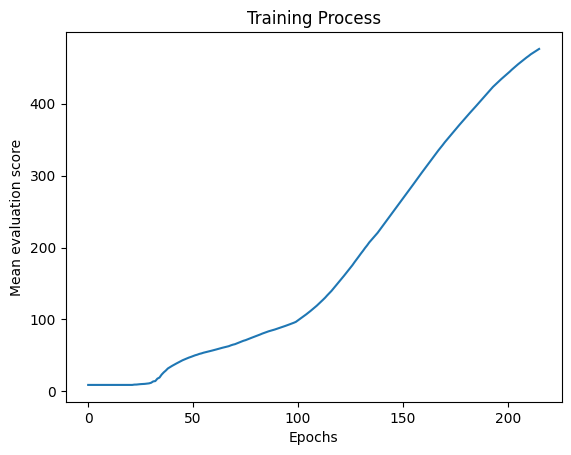

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dueling_ddqn_agent.mean_eval_scores)
plt.xlabel("Epochs")
plt.ylabel("Mean evaluation score")
plt.title("Training Process")
plt.show()

# Let our Dueling DDQN with PER agent play CartPole

In [ ]:
import os
import imageio
from PIL import Image as Im
import PIL.ImageDraw as ImageDraw
from IPython import display

In [ ]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # get the initial state
    state = env.reset()

    # for each timestep, do the following
    for t in range(500):
      # get the Q-value estimates
      q_values = dueling_ddqn_agent.online_model(state, training = False).numpy().squeeze()
      # select the action (greedily)
      action = np.argmax(q_values)

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode+1}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Tensorflow/Dueling DDQN with PER/Gif/', 'Dueling_DDQN_with_PER_agent.gif'), frames, duration=20)

In [ ]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


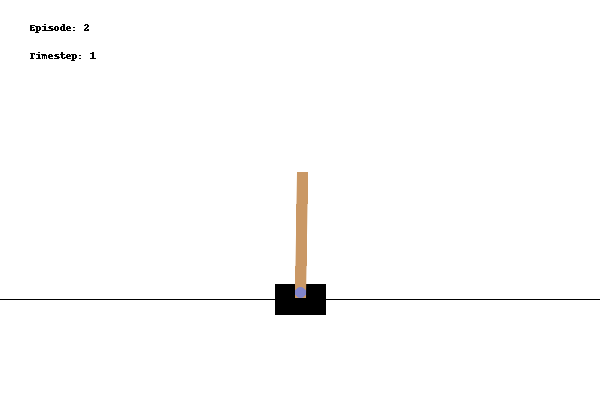

In [ ]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Tensorflow/Dueling DDQN with PER/Gif/Dueling_DDQN_with_PER_agent.gif','rb').read())